
--- Processando: Natal, Rio Grande do Norte, Brazil ---
Encontrados 76 shoppings, mapeados para 74 nós de rede.
Processamento de Natal, Rio Grande do Norte, Brazil concluído.

--- Processando: Aracaju, Sergipe, Brazil ---
Encontrados 33 shoppings, mapeados para 31 nós de rede.
Processamento de Aracaju, Sergipe, Brazil concluído.

--- Processando: João Pessoa, Paraíba, Brazil ---
Encontrados 39 shoppings, mapeados para 37 nós de rede.
Processamento de João Pessoa, Paraíba, Brazil concluído.

--- Processando: São Luís, Maranhão, Brazil ---
Encontrados 139 shoppings, mapeados para 124 nós de rede.
Processamento de São Luís, Maranhão, Brazil concluído.

--- Processando: Teresina, Piauí, Brazil ---
Encontrados 10 shoppings, mapeados para 10 nós de rede.
Processamento de Teresina, Piauí, Brazil concluído.

--- Processando: Palmas, Tocantins, Brazil ---
Encontrados 4 shoppings, mapeados para 4 nós de rede.
Processamento de Palmas, Tocantins, Brazil concluído.

--- Processando: Mossoró, Rio G

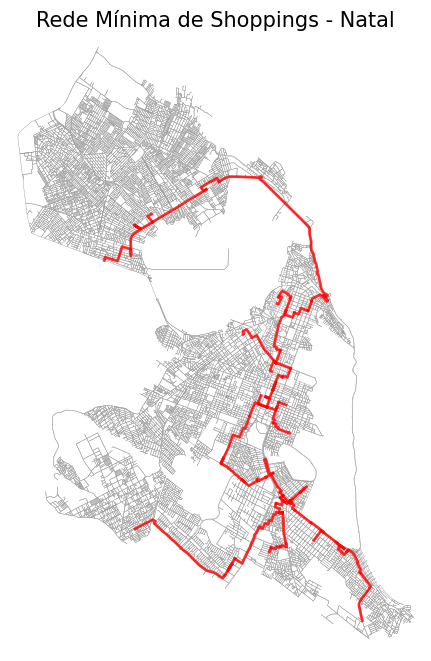

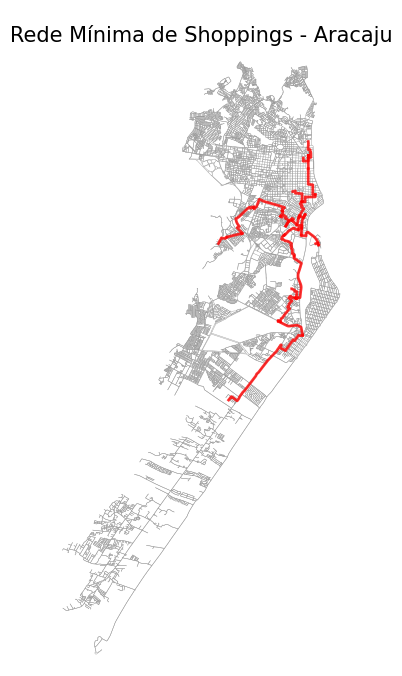

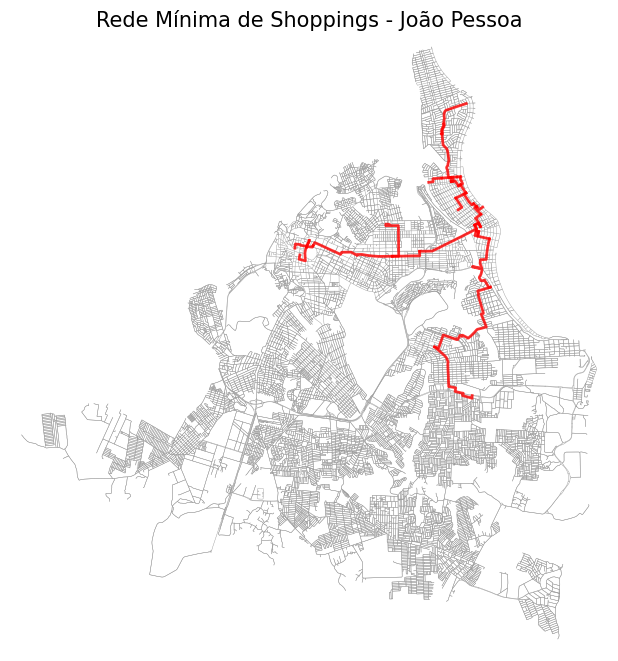

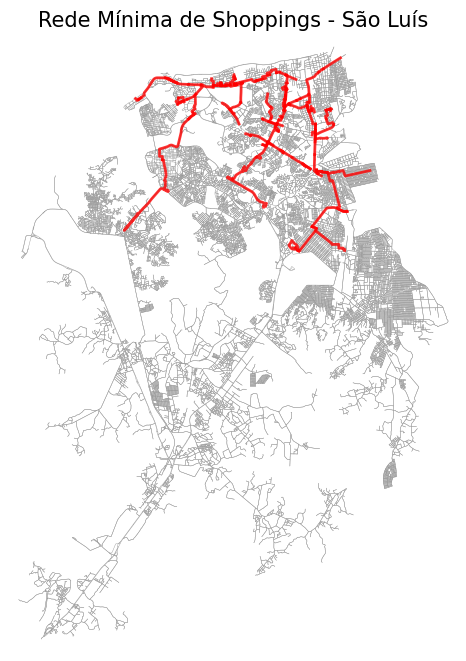

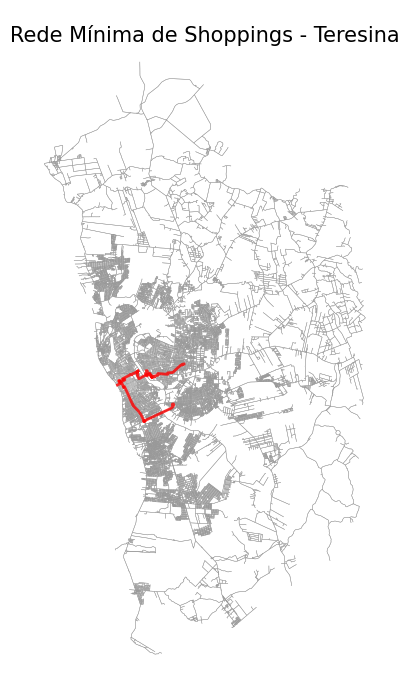

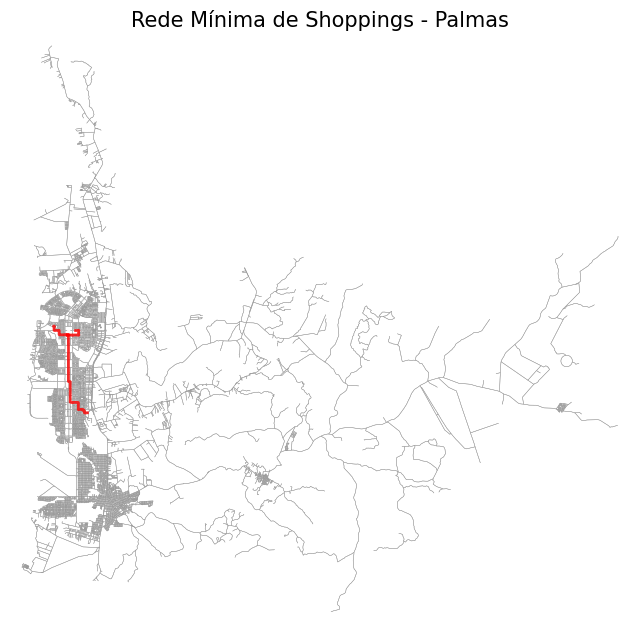

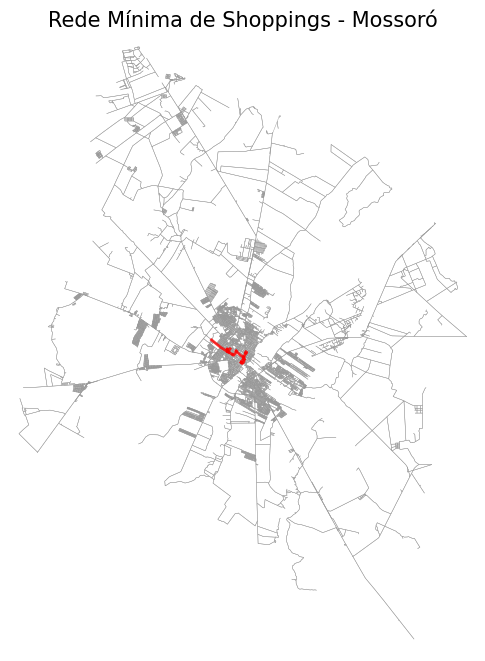

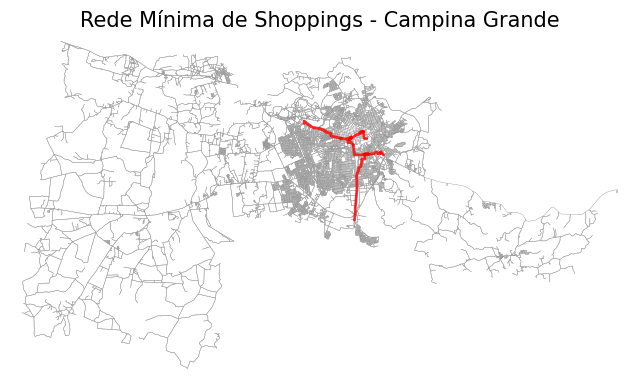

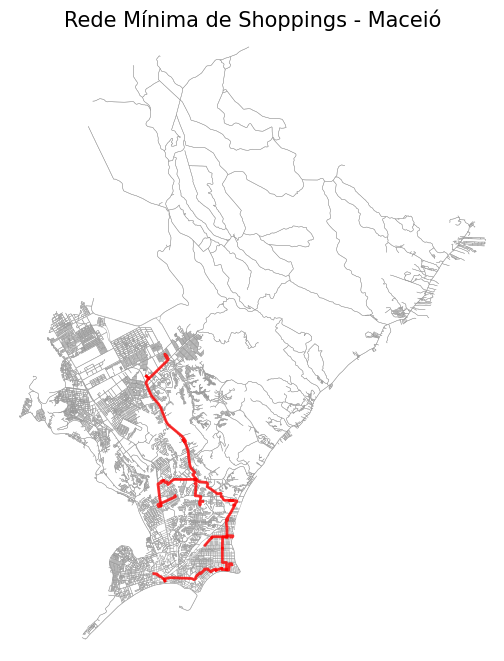

Análise finalizada.


In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings

# Configurações do OSMnx
ox.settings.log_console = False
ox.settings.use_cache = True

def estimate_poi_network(city_name):
    """
    Executa a análise completa (Passos 1-4) para uma única cidade.
    """
    print(f"\n--- Processando: {city_name} ---")

    try:
        # -----------------------------------------------------------------
        # Passo 1 & 2: Baixar POIs (Shoppings) e Grafo Viário
        # -----------------------------------------------------------------

        # Baixa o grafo viário
        G = ox.graph_from_place(city_name, network_type='drive')

        # Projeta o grafo para UTM (métrico)
        G_proj = ox.project_graph(G)

        # Baixa os POIs (shoppings)
        tags = {'shop': 'mall'}
        pois = ox.features_from_place(city_name, tags=tags)

        # Filtra para geometrias válidas (Pontos e Polígonos)
        pois = pois[pois.geometry.is_valid & (~pois.geometry.is_empty)]

        if len(pois) < 2:
            print(f"Não foram encontrados 2 ou mais shoppings em {city_name}. Pulando.")
            return None

        # Projeta os POIs para o mesmo CRS do grafo
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
        # ESTA É A LINHA CORRIGIDA
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
        pois_proj = pois.to_crs(G_proj.graph['crs'])
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

        # -----------------------------------------------------------------
        # Passo 3: Mapear POIs e Calcular Rotas A*
        # -----------------------------------------------------------------

        # Para cada POI, pega o nó mais próximo no grafo
        # Usamos os centroides dos polígonos/pontos
        poi_nodes = ox.nearest_nodes(G_proj,
                                     X=pois_proj.geometry.centroid.x,
                                     Y=pois_proj.geometry.centroid.y)

        # Remove duplicatas (shoppings diferentes mapeados para o mesmo nó)
        unique_poi_nodes = list(set(poi_nodes))

        if len(unique_poi_nodes) < 2:
            print(f"POIs mapeados para menos de 2 nós únicos em {city_name}. Pulando.")
            return None

        print(f"Encontrados {len(pois)} shoppings, mapeados para {len(unique_poi_nodes)} nós de rede.")

        # Cria a função de heurística A* (distância Euclidiana no plano UTM)
        def heuristic(u, v):
            """Heurística Euclidiana para A*."""
            n1 = G_proj.nodes[u]
            n2 = G_proj.nodes[v]
            return np.sqrt((n1['x'] - n2['x'])**2 + (n1['y'] - n2['y'])**2)

        # Cria um grafo completo "virtual" H para armazenar distâncias A*
        H = nx.Graph()

        # Calcula o caminho mínimo A* para cada par de POIs
        for u, v in itertools.combinations(unique_poi_nodes, 2):
            try:
                # Calcula o comprimento e o caminho
                length = nx.astar_path_length(G_proj, u, v,
                                              heuristic=heuristic,
                                              weight='length')

                path = nx.astar_path(G_proj, u, v,
                                     heuristic=heuristic,
                                     weight='length')

                # Adiciona a aresta ao grafo completo H
                H.add_edge(u, v, weight=length, path=path)

            except nx.NetworkXNoPath:
                print(f"Sem caminho entre os nós {u} e {v} em {city_name}.")
                continue

        # -----------------------------------------------------------------
        # Passo 4: Calcular a MST sobre o grafo completo H
        # -----------------------------------------------------------------

        if H.number_of_nodes() == 0 or not nx.is_connected(H):
            print(f"O grafo de rotas A* não é conexo em {city_name}. Pulando.")
            return None

        # Calcula a MST usando o algoritmo de Kruskal
        mst = nx.minimum_spanning_tree(H, weight='weight', algorithm='kruskal')

        # Métrica 1: Comprimento total da MST (soma dos pesos A*)
        mst_total_length_m = mst.size(weight='weight')

        # Coleta as rotas (listas de nós) que compõem a MST
        mst_routes = [data['path'] for u, v, data in mst.edges(data=True)]

        # Métrica 2: Comprimento total da rede real (união das rotas)
        # Isso conta segmentos de estrada compartilhados apenas uma vez
        all_edges_in_routes = set()
        for route in mst_routes:
            # Garante que as arestas sejam tuplas (u, v) onde u <= v
            route_edges = [tuple(sorted(edge)) for edge in zip(route[:-1], route[1:])]
            all_edges_in_routes.update(route_edges)

        real_network_length_m = 0
        for u, v in all_edges_in_routes:
            # Acessa o comprimento da aresta no grafo projetado
            # G_proj pode ter múltiplas arestas (ex: ida/volta), mas 'length'
            # deve ser a mesma. Pegamos a chave 0 (padrão).
            if G_proj.has_edge(u, v):
                 real_network_length_m += G_proj[u][v][0]['length']
            elif G_proj.has_edge(v, u): # Checa direção oposta se for digrafo
                 real_network_length_m += G_proj[v][u][0]['length']


        # Coleta estatísticas das arestas da MST (distâncias A*)
        mst_edge_lengths_m = [data['weight'] for u, v, data in mst.edges(data=True)]
        num_pois = len(unique_poi_nodes)
        num_mst_edges = mst.number_of_edges()

        if num_mst_edges > 0:
            avg_edge_len_m = np.mean(mst_edge_lengths_m)
            std_edge_len_m = np.std(mst_edge_lengths_m)
        else:
            avg_edge_len_m = 0
            std_edge_len_m = 0

        # Compila os resultados
        result = {
            'Cidade': city_name.split(',')[0],
            'POIs (Shoppings)': num_pois,
            'Arestas na MST': num_mst_edges,
            'Compr. Total MST (km)': mst_total_length_m / 1000.0,
            'Compr. Rede Real (km)': real_network_length_m / 1000.0,
            'Compr. Médio Aresta MST (km)': avg_edge_len_m / 1000.0,
            'Desv. Padrão Aresta MST (km)': std_edge_len_m / 1000.0,
            'G_proj': G_proj, # Para plotagem
            'mst_routes': mst_routes # Para plotagem
        }

        print(f"Processamento de {city_name} concluído.")
        return result

    except Exception as e:
        print(f"Falha ao processar {city_name}: {e}")
        return None

# -----------------------------------------------------------------
# Passo 5: Comparação entre Cidades
# -----------------------------------------------------------------
cities = [
    "Natal, Rio Grande do Norte, Brazil",
    "Aracaju, Sergipe, Brazil",
    "João Pessoa, Paraíba, Brazil",
    "São Luís, Maranhão, Brazil",
    "Teresina, Piauí, Brazil",
    "Palmas, Tocantins, Brazil",
    "Maceió, Alagoas, Brazil",
    "Fortaleza, Ceará, Brazil",
    "Recife, Pernambuco, Brazil"
]

all_results = []
plot_data = {}

# Ignora avisos de depreciação do geopandas/pyproj
warnings.filterwarnings('ignore', category=FutureWarning)

for city in cities:
    res = estimate_poi_network(city)
    if res:
        all_results.append(res)
        # Guarda dados de plotagem separadamente
        plot_data[res['Cidade']] = {
            'G_proj': res.pop('G_proj'),
            'mst_routes': res.pop('mst_routes')
        }

# -----------------------------------------------------------------
# Passo 6: Visualização e Análise (Tabela)
# -----------------------------------------------------------------
print("\n\n--- Análise Comparativa Concluída ---")

if all_results:
    df_results = pd.DataFrame(all_results)

    # Adiciona métricas normalizadas (km/POI)
    df_results['MST (km/POI)'] = df_results['Compr. Total MST (km)'] / df_results['POIs (Shoppings)']
    df_results['Rede Real (km/POI)'] = df_results['Compr. Rede Real (km)'] / df_results['POIs (Shoppings)']

    # Formata para melhor visualização
    df_results = df_results.round(2)

    # Define a ordem das colunas
    columns_order = [
        'Cidade',
        'POIs (Shoppings)',
        'Compr. Total MST (km)',
        'Compr. Rede Real (km)',
        'MST (km/POI)',
        'Rede Real (km/POI)',
        'Compr. Médio Aresta MST (km)',
        'Desv. Padrão Aresta MST (km)'
    ]

    df_display = df_results[columns_order].sort_values(by='MST (km/POI)')

    print("\nTabela Comparativa de Métricas da Rede de Shoppings:")
    print(df_display.to_markdown(index=False))

else:
    print("Nenhuma cidade foi processada com sucesso.")

# -----------------------------------------------------------------
# Passo 6: Visualização e Análise (Gráficos)
# -----------------------------------------------------------------
print("\nGerando visualizações das redes...")

for cidade, data in plot_data.items():
    G_proj = data['G_proj']
    mst_routes = data['mst_routes']

    if not mst_routes:
        print(f"Sem rotas para plotar em {cidade}.")
        continue

    # Plota o grafo de ruas e as rotas da MST sobrepostas
    fig, ax = ox.plot_graph_routes(
        G_proj,
        mst_routes,
        route_colors='r',
        route_linewidths=2,
        route_alpha=0.8,
        orig_dest_size=0,
        ax=None,
        node_size=0,
        edge_linewidth=0.3,
        edge_color='#999999',
        bgcolor='w',
        show=False,
        close=False
    )

    ax.set_title(f"Rede Mínima de Shoppings - {cidade}", fontsize=15)

    # Salva a figura (opcional)
    # plt.savefig(f"rede_shoppings_{cidade}.png", dpi=300, bbox_inches='tight')

    plt.show()

print("Análise finalizada.")